In [455]:
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import time
from scipy.cluster.vq import whiten, kmeans
import matplotlib.pyplot as plt
from numpy import linalg as LA
from networkx.algorithms.cuts import conductance
import os
%matplotlib inline

## Reproducing the results

In [525]:
# Custom spectral clustering
from scipy.sparse.linalg import eigsh
def spectral_clust(A, k=2):
    n = np.shape(A)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A.sum(axis=0))))
    L = np.identity(n) - D.dot(A).dot(D)
    V, Z = eigsh(L, 2, which='SM')
    
    rows_norm = np.linalg.norm(Z, axis=1, ord=2)
    Y = (Z.T / rows_norm).T
    centroids, distortion = kmeans(Y, k)
    
    y_hat = np.zeros(n, dtype=int)
    for i in range(n):
        dists = np.array([np.linalg.norm(Y[i] - centroids[c]) for c in range(k)])
        y_hat[i] = np.argmin(dists)
    return y_hat

In [460]:
# Load the data
def read_graph(filepath, source_graph=None):
    # Use the largest connected component from the graph
    if source_graph is None:
        graph = nx.read_edgelist(filepath, nodetype=int).to_undirected()
    else:
        graph = source_graph
    graph = max(nx.connected_component_subgraphs(graph), key=len)
    
    # Split the graph edges into train and test
    random_edges = list(graph.edges())
    np.random.shuffle(random_edges)
    train_edges = random_edges[:graph.number_of_edges()//2]
    test_edges = random_edges[graph.number_of_edges()//2:]
    
    # Create the training graph
    train_graph = nx.Graph()
    train_graph.add_edges_from(train_edges)
    train_graph = max(nx.connected_component_subgraphs(train_graph), key=len)
    
    # Create the test graph
    test_graph = nx.Graph()
    test_graph.add_nodes_from(train_graph.nodes())
    test_graph.add_edges_from(test_edges)
    
    return train_graph, test_graph

def generate_dangling_random_graph():
    graph = nx.gaussian_random_partition_graph(200, 100, 10, 0.4, 0.05)
    graph.add_path([1, 300, 1234, 500, 280, 267, 221, 500, 300, 267, 221])
    graph.add_path([2, 301, 1231, 501, 281, 261, 222, 501, 301, 261, 222])
    graph.add_path([182, 3012, 12312, 5012, 2812, 2612, 2222, 5021, 3021, 2621, 2222])
    return graph

In [133]:
graph_map = {
    1: './dataset/email-Eu-core.txt',
    2: './dataset/0.edges',
    3: './dataset/gnutella08.txt',
    4: './dataset/as20000102.txt',
    5: './dataset/as19991212.txt',
    6: './dataset/ca-GrQc.txt',
    7: './dataset/as19991221.txt',
    8: './dataset/twitter',
    9: './dataset/tvshow.txt',
    10: './dataset/politicians.txt',
    11: './dataset/as19991230.txt',
    12: './dataset/as19971111.txt',
}

In [134]:
# Compute the size of the smallest partition
def get_min_part_size(labels):
    return min(np.sum(labels), np.size(labels) - np.sum(labels))

def get_avg_min_part_size(map_entry):
    van_part, reg_part = [], []
    for seed in range(0, 3):
        np.random.seed(seed)
        train, _ = read_graph(graph_map[map_entry])
        
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tao = train.number_of_edges() * 2 / N
        SR = S + tao / N
        
        sc_van = SpectralClustering(2, affinity='precomputed', n_init=10, n_jobs=-1).fit(S)
        sc_reg = SpectralClustering(2, affinity='precomputed', n_init=10, n_jobs=-1).fit(SR)
        
        van_part.append(get_min_part_size(sc_van.labels_))
        reg_part.append(get_min_part_size(sc_reg.labels_))
    
    return np.mean(van_part), np.mean(reg_part), N

def graphs_part_sizes():
    van_sizes, reg_sizes, graph_sizes = [], [], []
    for graph_key in graph_map:
        print('Processing ' + graph_map[graph_key])
        van, reg, size = get_avg_min_part_size(graph_key)
        van_sizes.append(van)
        reg_sizes.append(reg)
        graph_sizes.append(size)
    return van_sizes, reg_sizes, graph_sizes

In [135]:
van_sizes, reg_sizes, sizes = graphs_part_sizes()

Processing ./dataset/email-Eu-core.txt
Processing ./dataset/0.edges
Processing ./dataset/gnutella08.txt
Processing ./dataset/as20000102.txt
Processing ./dataset/as19991212.txt
Processing ./dataset/ca-GrQc.txt
Processing ./dataset/as19991221.txt
Processing ./dataset/twitter
Processing ./dataset/tvshow.txt
Processing ./dataset/politicians.txt
Processing ./dataset/as19991230.txt
Processing ./dataset/as19971111.txt


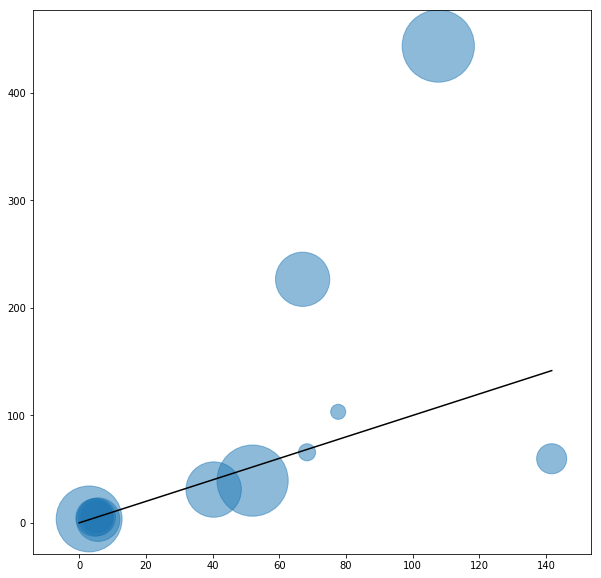

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
maxim = max(np.max(van_sizes), np.max(reg_sizes))
ax.plot([0, np.max(reg_sizes)], [0, np.max(reg_sizes)], color='black')
ax.scatter(reg_sizes, van_sizes, sizes, alpha=0.5)

In [141]:
def get_conductance(map_entry):
    van_cond_train, van_cond_test = [], []
    reg_cond_train, reg_cond_test = [], []
    for seed in range(0, 5):
        np.random.seed(seed)
        train, test = read_graph(graph_map[map_entry])
        
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tao = train.number_of_edges() * 2 / N
        SR = S + tao / N
        
        sc_van = SpectralClustering(2, affinity='precomputed', n_init=10, n_jobs=-1).fit(S)
        sc_reg = SpectralClustering(2, affinity='precomputed', n_init=10, n_jobs=-1).fit(SR)
        
        nodes = np.array(list(train.nodes()))
        van_cond_train.append(conductance(train, nodes[sc_van.labels_ == 1]))
        van_cond_test.append(conductance(test, nodes[sc_van.labels_ == 1]))
        reg_cond_train.append(conductance(train, nodes[sc_reg.labels_ == 1]))
        reg_cond_test.append(conductance(test, nodes[sc_reg.labels_ == 1]))
    
    return np.mean(van_cond_train), np.mean(reg_cond_train), np.mean(van_cond_test), np.mean(reg_cond_test), N
    
def graphs_conductances():
    van_train, reg_train, van_test, reg_test, sizes = [], [], [], [], []
    for graph_key in graph_map:
        print('Processing graph ' + graph_map[graph_key])
        vt, rt, vtes, rtes, s = get_conductance(graph_key)
        van_train.append(vt)
        reg_train.append(rt)
        van_test.append(vtes)
        reg_test.append(rtes)
        sizes.append(s)
        
    return van_train, reg_train, van_test, reg_test, sizes

In [142]:
van_train, reg_train, van_test, reg_test, sizes = graphs_conductances()

Processing graph ./dataset/email-Eu-core.txt
Processing graph ./dataset/0.edges
Processing graph ./dataset/gnutella08.txt
Processing graph ./dataset/as20000102.txt
Processing graph ./dataset/as19991212.txt
Processing graph ./dataset/ca-GrQc.txt
Processing graph ./dataset/as19991221.txt
Processing graph ./dataset/twitter
Processing graph ./dataset/tvshow.txt
Processing graph ./dataset/politicians.txt
Processing graph ./dataset/as19991230.txt
Processing graph ./dataset/as19971111.txt


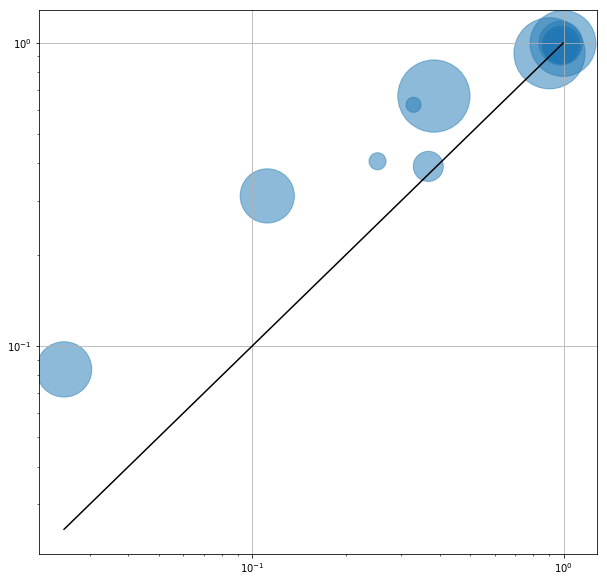

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
minim = min(np.min(van_train), np.min(reg_train))
maxim = max(np.max(van_train), np.max(reg_train))
ax.plot([minim, maxim], [minim, maxim], color='black')
ax.grid(True)
ax.scatter(reg_train, van_train, sizes, alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')

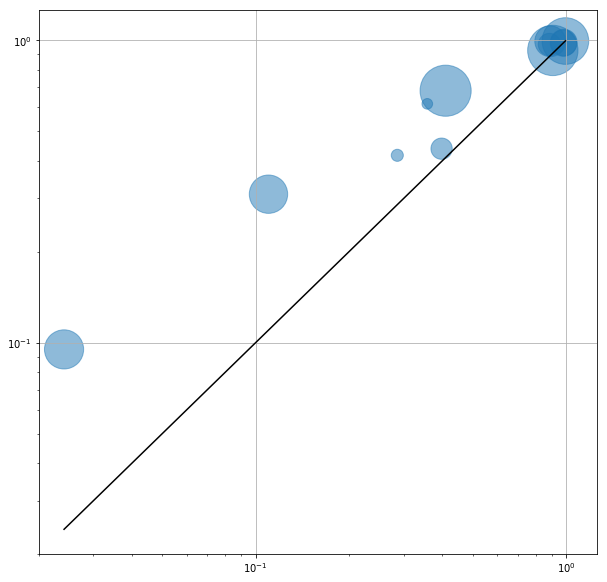

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
minim = min(np.min(van_test), np.min(reg_test))
maxim = max(np.max(van_test), np.max(reg_test))
ax.plot([minim, maxim], [minim, maxim], color='black')
ax.grid(True)
ax.scatter(reg_test, van_test, np.array(sizes) * 0.5, alpha=0.5, )
ax.set_yscale('log')
ax.set_xscale('log')

In [126]:
def get_eigen(A):
    DS = np.diag(1. / np.sqrt(np.ravel((np.sum(A, 1)))))
    L = np.identity(np.shape(A)[0]) - np.matmul(np.matmul(DS, A), DS)
    val, vec = LA.eigh(L, eigvals=(0, 2))
    return 1 - val, np.matmul(DS, vec).real

def benchmark(fct, runs=3): 
    times = []
    for run in range(runs):
        start = time.time()
        fct()
        end = time.time()
        times.append(end-start)
    return np.mean(times)

def graphs_benchmark():
    vant, regt, sizes = [], [], []
    for graph_key in graph_map:
        print('Processing graph ' + graph_map[graph_key])
       
        train, _ = read_graph(graph_map[graph_key])
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tau = 2 * train.number_of_edges() / N
        SR = S + tao / N

        vant.append(benchmark(lambda: get_eigen(S)))
        regt.append(benchmark(lambda: get_eigen(SR)))
        sizes.append(train.number_of_nodes())

    return vant, regt, sizes

In [127]:
van_times, reg_time, sizes = graphs_benchmark()

Processing graph ./dataset/email-Eu-core.txt
Processing graph ./dataset/0.edges
Processing graph ./dataset/gnutella08.txt
Processing graph ./dataset/as20000102.txt
Processing graph ./dataset/as19991212.txt
Processing graph ./dataset/ca-GrQc.txt
Processing graph ./dataset/oregon1_010407.txt
Processing graph ./dataset/twitter
Processing graph ./dataset/tvshow.txt
Processing graph ./dataset/politicians.txt
Processing graph ./dataset/gnutella09.txt


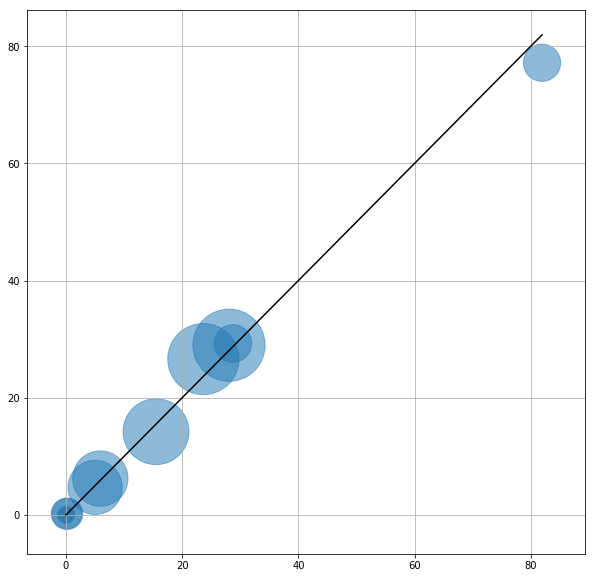

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
maxim = max(np.max(van_times), np.max(reg_time))
ax.plot([0, maxim], [0, maxim], color='black')
ax.grid(True)
ax.scatter(reg_time, van_times, sizes, alpha=0.5)

## Analyse an individual graph in detail

In [308]:
np.random.seed(8)
# train_graph, test_graph = read_graph(graph_map[11])
# train_graph, test_graph = read_graph('', nx.karate_club_graph())
# train_graph, test_graph = read_graph('', nx.davis_southern_women_graph())
# train_graph, test_graph = read_graph('', nx.florentine_families_graph())
# train_graph, test_graph = read_graph('', generate_dangling_random_graph())
train_graph, test_graph = read_graph('', nx.read_gml('./dataset/polblogs.gml').to_undirected())

In [353]:
# Compare the eigenvectors of the markov matrix of the vanilla and regularised graphs
S = nx.to_numpy_matrix(train_graph)

# Tao is initialised with the average degree of the graph
N = train_graph.number_of_nodes()
tao = 2.25
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

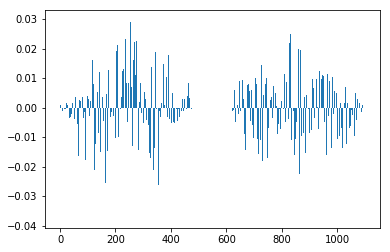

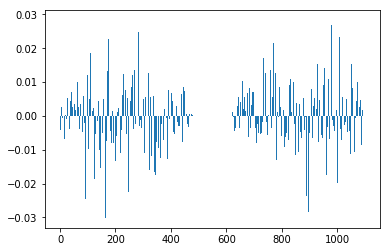

In [354]:
# Compare the eigenvectors of the laplacian of the two graphs
def plot_array(eigenval):
    plt.bar(np.arange(len(eigenval)), eigenval)
    plt.show()
    
plot_array(np.ravel(vec_van[2, :]))
plot_array(np.ravel(vec_reg[2, :]))

In [355]:
# Compute the number of nodes in the smallest partition set.
sc_van = SpectralClustering(2, affinity='precomputed', n_init=100).fit(S)
sc_reg = SpectralClustering(2, affinity='precomputed', n_init=100).fit(SR)

In [356]:
# Compute the conductange of the smallest set
nodes = np.array(list(train_graph.nodes()))
van_nodes_with_label = nodes[sc_van.labels_ == 1]
reg_nodes_with_label = nodes[sc_reg.labels_ == 1]

print("Vanilla conductance on train: {}".format(conductance(train_graph, van_nodes_with_label)))
print("CoreCut conductance on train: {}".format(conductance(train_graph, reg_nodes_with_label)))
print("Vanilla conductance on test: {}".format(conductance(test_graph, van_nodes_with_label)))
print("CoreCut conductance on test: {}".format(conductance(test_graph, reg_nodes_with_label)))

Vanilla conductance on train: 0.37829485548082165
CoreCut conductance on train: 0.33309671694764864
Vanilla conductance on test: 0.40664869721473496
CoreCut conductance on test: 0.36620739666424945


In [357]:
def node_colors(labels):
    colors = np.empty_like(labels, dtype=object)
    colors[labels == 1] = 'orange'
    colors[labels == 0] = 'cornflowerblue'
    return colors

def draw_bipartite_graph(graph, nodelist, labels):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20));
    nx.draw_networkx(graph, ax=ax, with_labels=False, nodelist=nodelist, 
                     node_color=node_colors(labels), node_size=50)

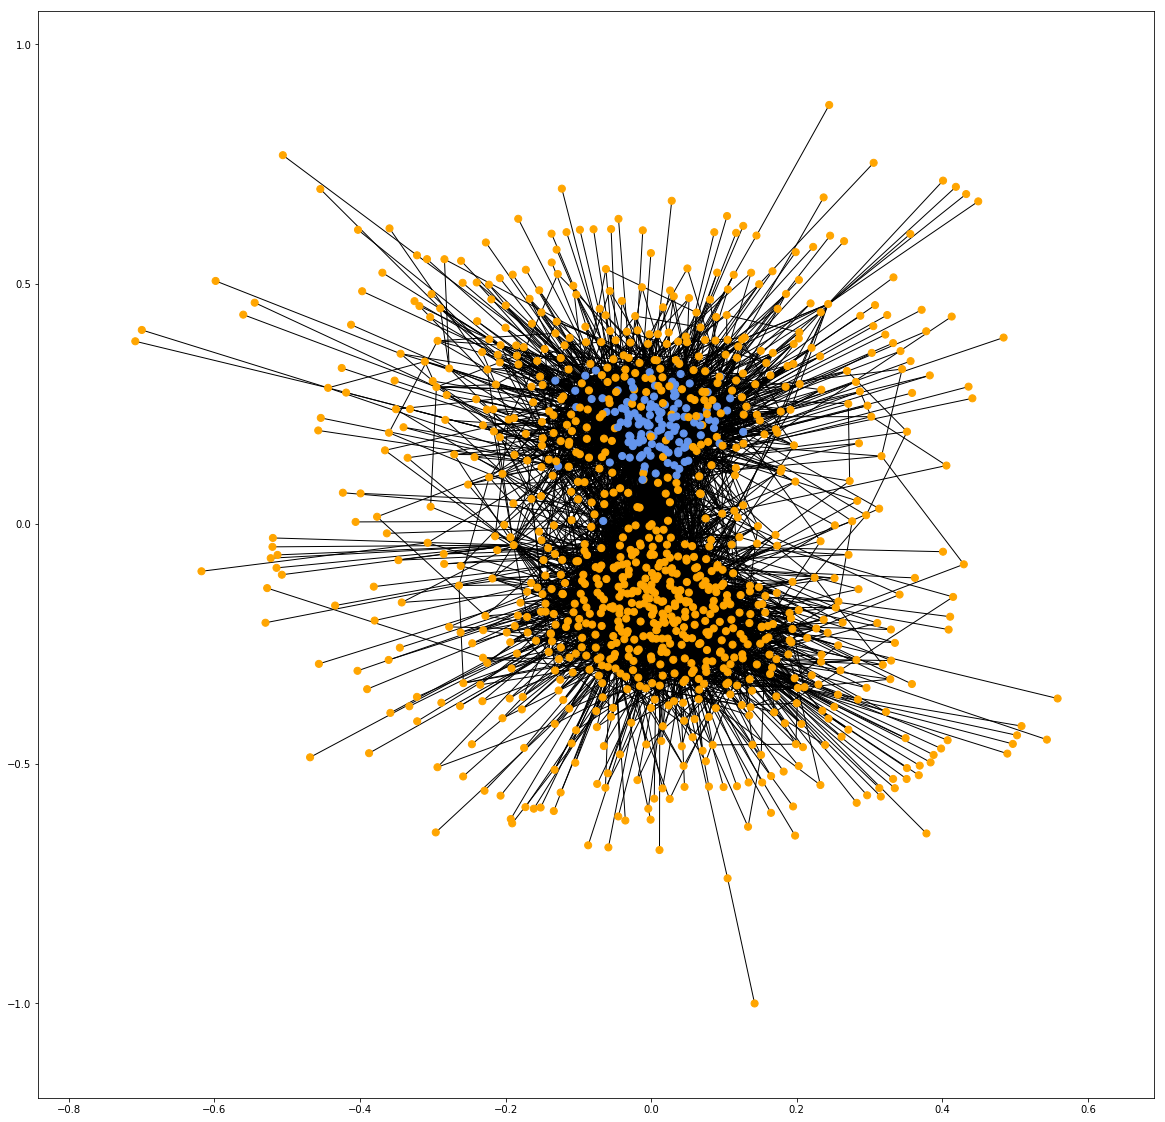

In [358]:
draw_bipartite_graph(train_graph, list(train_graph.nodes()), sc_van.labels_)

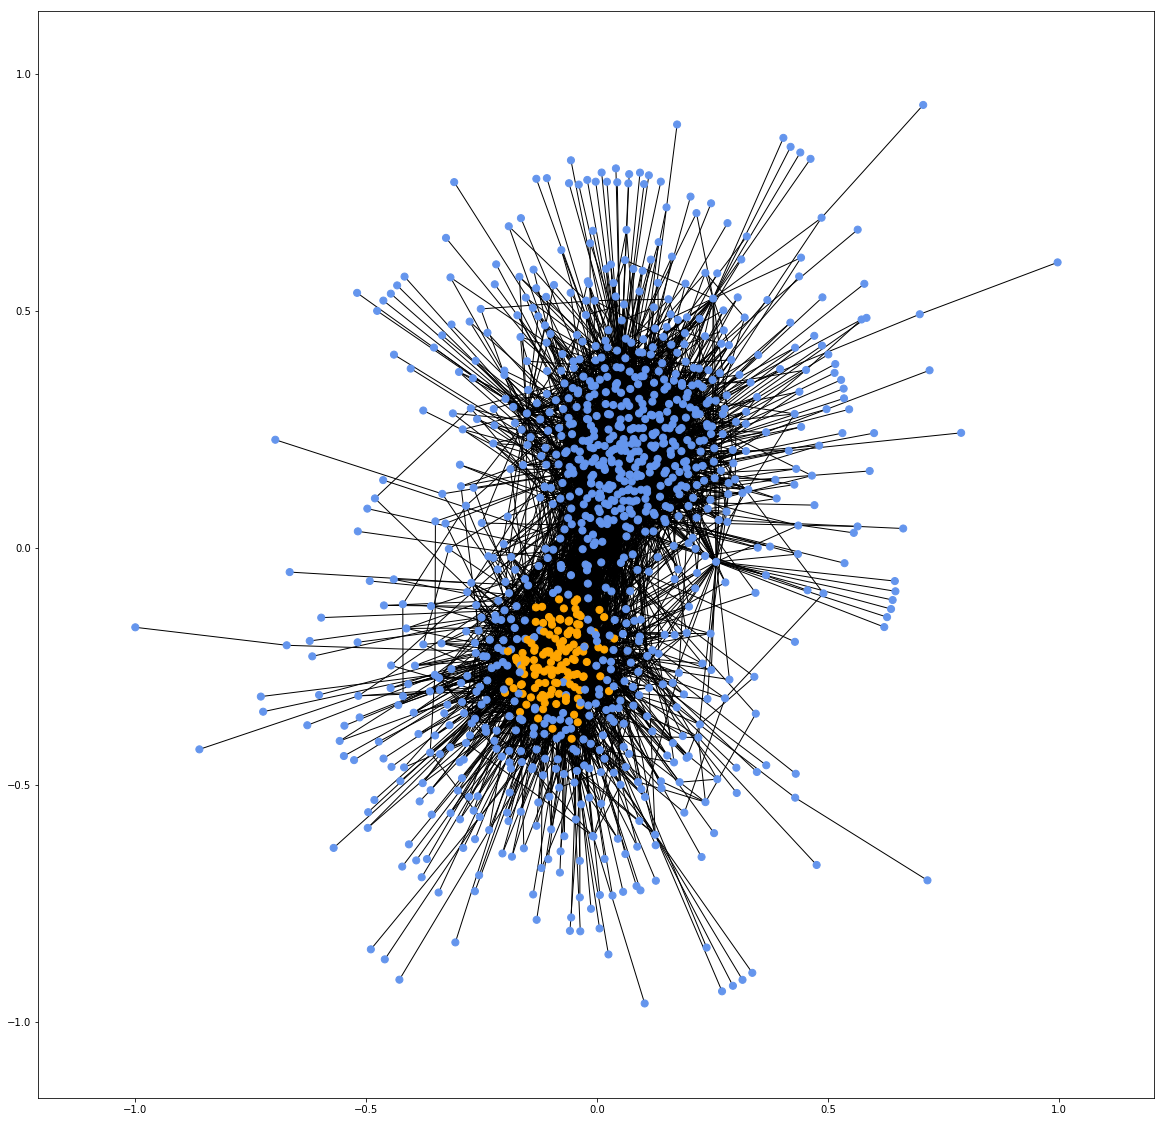

In [359]:
draw_bipartite_graph(train_graph, list(train_graph.nodes()), sc_reg.labels_)

In [ ]:
# Bechmark the execution time for the computation of eigenvalues for the two matrices
def benchmark(fct):   
    start = time.time()
    fct()
    end = time.time()
    return end-start

van_times, reg_times = [], []
runs = 10

for run in range(runs):
    van_times.append(benchmark(lambda: get_eigen(S)))
    reg_times.append(benchmark(lambda: get_eigen(SR)))

print("{}+-{}".format(np.mean(van_times), np.std(van_times)))
print("{}+-{}".format(np.mean(reg_times), np.std(reg_times)))

## Experiments with more clusters on radom graphs

In [288]:
def generate_dangling_random_graph():
    graph = nx.gaussian_random_partition_graph(400, 100, np.inf, 0.4, 0.01)
    graph.add_path([1, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007])
    graph.add_path([150, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])
    graph.add_path([350, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007])
    return graph

rgraph = generate_dangling_random_graph()
S = nx.to_numpy_matrix(rgraph)
SR = S + (rgraph.number_of_edges() * 2 / np.shape(S)[0]**2)

In [289]:
sc_van = SpectralClustering(4, affinity='precomputed', n_init=10).fit(S)
sc_reg = SpectralClustering(4, affinity='precomputed', n_init=10).fit(SR)

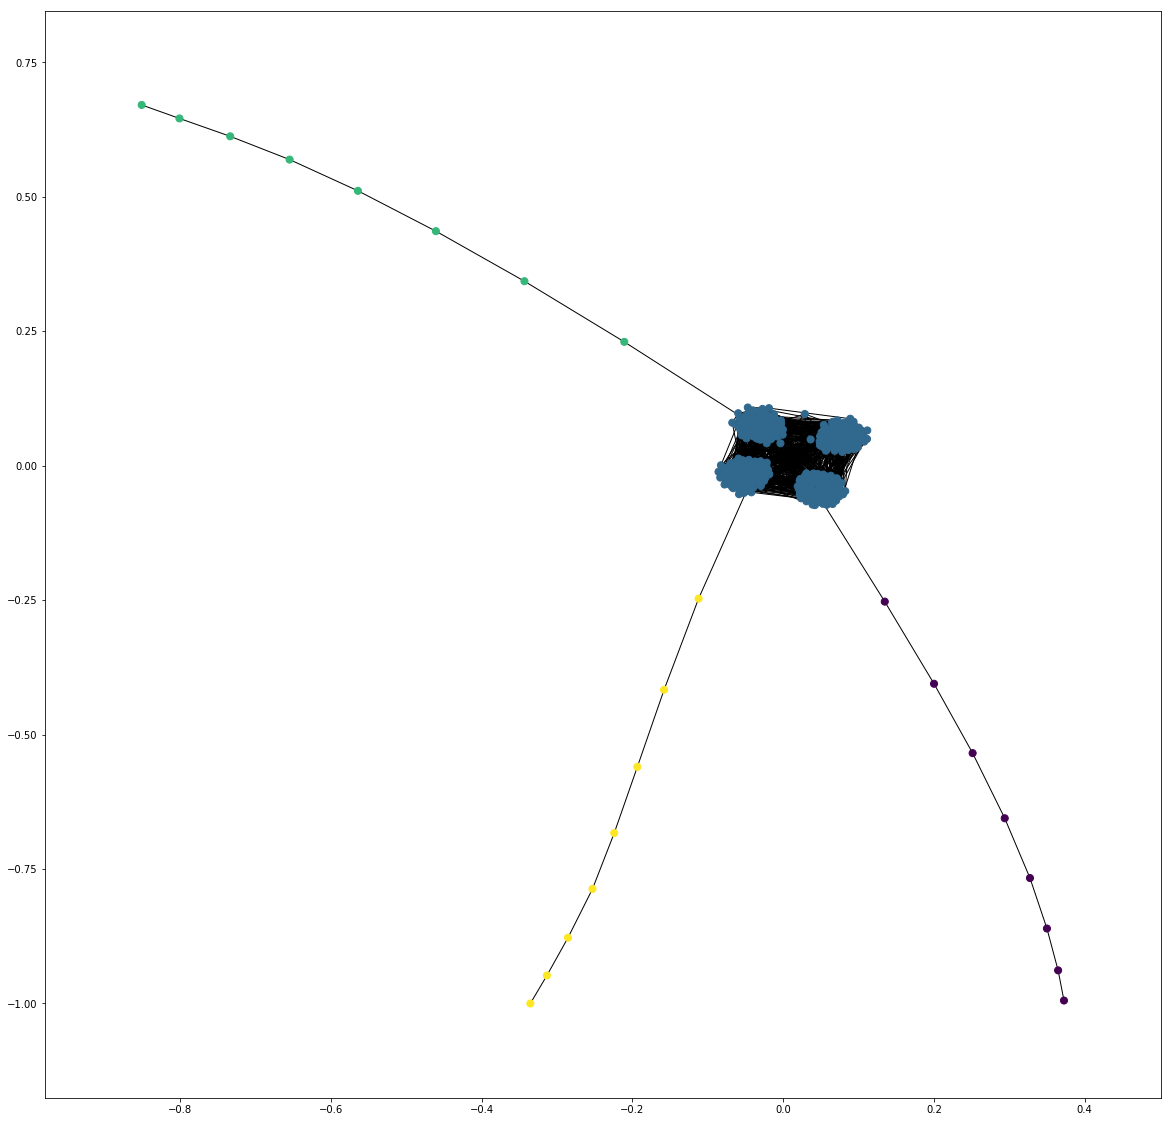

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(),
                 node_color=sc_van.labels_, node_size=50)

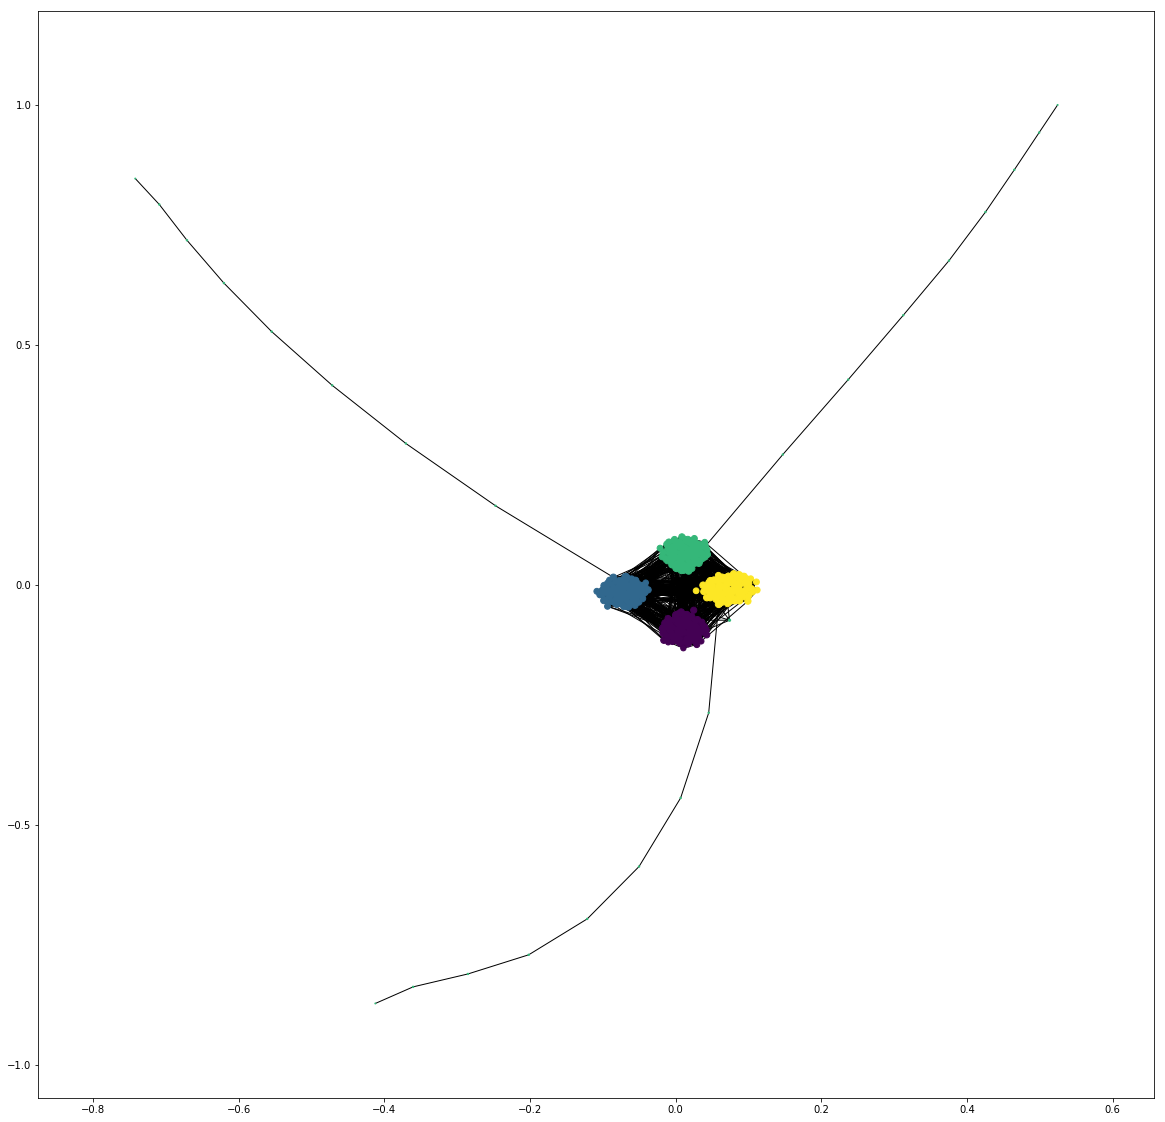

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(), node_color=sc_reg.labels_, 
                 node_size=np.ravel(np.sum(S, axis=0)))

## Experiments with more clusters on real graphs

### Showing that regularisation reduces the variance of the cluster size

In [277]:
# train, test = read_graph("./dataset/twitter")
train, test = read_graph(graph_map[9])
S = nx.to_numpy_matrix(train)

# Tau is initialised with the average degree of the graph
N = train.number_of_nodes()
tao = train.number_of_edges() * 2 / N
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

In [278]:
size_std_van, size_std_reg = [], []
def size_std(labels):
    sizes = np.bincount(labels)
    return np.std(sizes)

def avg_conductance(labels, nodes, graph):
    conductances = []
    for label in np.unique(labels):
        partition = np.ravel(nodes[labels == label])
        conductances.append(conductance(graph, partition))
    return np.mean(conductances)
        

clusters = 20

cond_van, cond_reg = [], []
cond_tvan, cond_treg = [], []
nodes = np.array(train.nodes())
for number_of_clusters in range(2, clusters):
    van = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=10).fit(S)
    reg = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=10).fit(SR)
    
    size_std_van.append(size_std(van.labels_))    
    size_std_reg.append(size_std(reg.labels_))
    
    cond_van.append(avg_conductance(van.labels_, nodes, train))
    cond_reg.append(avg_conductance(reg.labels_, nodes, train))   
    
    cond_tvan.append(avg_conductance(van.labels_, nodes, test))
    cond_treg.append(avg_conductance(reg.labels_, nodes, test))  

<Container object of 18 artists>

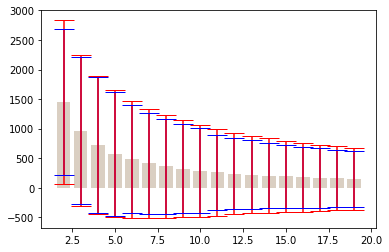

In [279]:
fig, ax = plt.subplots()
mean = N / np.arange(2, clusters)
ax.bar(np.arange(2, clusters), mean, yerr=size_std_van, alpha=0.2, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters), mean, yerr=size_std_reg, alpha=0.2, align='center', ecolor='red', capsize=10)

<Container object of 18 artists>

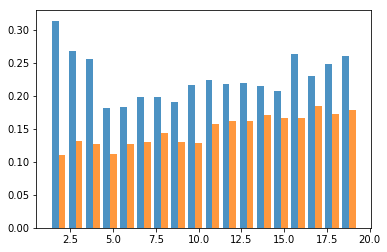

In [280]:
fig, ax = plt.subplots()
w=0.4
ax.bar(np.arange(2, clusters)-w, cond_van, width=w, alpha=0.8, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters), cond_reg, width=w, alpha=0.8, align='center', ecolor='red', capsize=10)

<Container object of 18 artists>

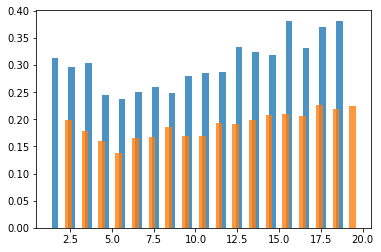

In [281]:
fig, ax = plt.subplots()
w=0.4
ax.bar(np.arange(2, clusters)-w, cond_tvan, width=w, alpha=0.8, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters)+w, cond_treg, width=w, alpha=0.8, align='center', ecolor='red', capsize=10)

## The effect of $\tau$ on regularisation

The graph below shows the effects of the regularisation parameter $\tau$ in the size of the minimum partition 

In [376]:
taos = np.linspace(0, 10, 400)
reg_sizes = []
conducts = []
conducts_test = []

tao_heurisitc = train.number_of_edges() * 2 / N
nodes = np.array(train.nodes())
for tao in taos:
    SR = S + tao 
    reg = SpectralClustering(2, affinity='precomputed', n_init=10).fit(SR)    
    
    reg_sizes.append(min(np.sum(reg.labels_), N - np.sum(reg.labels_)))
    conducts.append(avg_conductance(reg.labels_, nodes, train))
    conducts_test.append(avg_conductance(reg.labels_, nodes, test))

SR = S + tao_heurisitc / N
reg = SpectralClustering(2, affinity='precomputed', n_init=10).fit(SR)
size_heuristic = min(np.sum(reg.labels_), N - np.sum(reg.labels_))
conduc_heuristic = avg_conductance(reg.labels_, nodes, train)
conduc_heuristic_test = avg_conductance(reg.labels_, nodes, train)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, reg_sizes)
ax.axvline(x=(tao_heurisitc/N), color='red')
ax.grid(True)

The effect of the $\tau$ on conductance.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, conducts)
ax.plot(taos, conducts_test)
ax.axvline(x=(tao_heurisitc/N), color='red')
plt.gca().legend(('train','test'))
ax.grid(True)

### Analyse regularisation on political network

In [530]:
train = nx.read_gml('./dataset/polblogs.gml').to_undirected()
train = max(nx.connected_component_subgraphs(train), key=len)
S = nx.to_numpy_matrix(train)

# Get the true labels of the political network
true_labels = list(map(lambda node: node[1]['value'], list(train.nodes(data=True))))

In [531]:
# print(train.nodes(data=True))
print(train.number_of_nodes())
print(2 * train.number_of_edges() / train.number_of_nodes())

1222
27.46644844517185


In [ ]:
taos = np.linspace(0, 20, 400)
reg_sizes = []
conducts = []
conducts_test = []

N = train.number_of_nodes()
tao_heurisitc = train.number_of_edges() * 2 / N
nodes = np.array(train.nodes())
accuracies = []
for tao in taos:
    SR = S + tao / N 
    y_hat = spectral_clust(SR)
    accuracy = max(np.sum(y_hat == true_labels), np.sum((1 - y_hat) == true_labels)) / N
    accuracies.append(accuracy)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(taos, accuracies)
ax.grid(True)